<h1 align="center"> Assignment 2 </h1>

Link to runnable .ipynb file: https://github.com/Vortriz/MTH407/blob/main/labs/2/lab2.ipynb

In [2]:
using Plots
using DataFrames

#### All arithmetic is in base 4

In [3]:
base = 4

4

In [4]:
# pads the array A with zeros to the right to make it of length l
function rpad(A, l)
    if length(A) > l
        return A[1:l]
    else
        return vcat(A, zeros(Int, l - length(A)))
    end
end

rpad (generic function with 1 method)

In [5]:
# pads the array A with zeros to the left to make it of length l
function lpad(A, l)
    return vcat(zeros(Int, l - length(A)), A)
end

lpad (generic function with 1 method)

In [6]:
function add_mac(a, b)
    c = a + b

    return [c % base, c ÷ base]
end

add_mac (generic function with 1 method)

In [7]:
function mul_mac(a, b)
	c = a * b
    global count_mul += 1

	return [c % base, c ÷ base]
end

mul_mac (generic function with 1 method)

In [8]:
function add1(a, b, c)
	r₁, c₁ = add_mac(a[1], b[1])
	r₂, c₂ = add_mac(r₁, c)
	r₃, c₃ = add_mac(c₁, c₂)

	if length(b) == 1
		return [r₂, r₃]
	end

	return append!([r₂], add1(a[2:end], b[2:end], r₃))
end

add1 (generic function with 1 method)

In [9]:
function add(a, b)

    l = max(length(a), length(b))
    a, b = rpad(a, l), rpad(b, l)

    r = add1(a, b, 0)[1:l+1]

    return r
end

add (generic function with 1 method)

### 1. Implementing subtraction in base $B$

In [10]:
function com_mac(a)
    return @. base - 1 - a
end

com_mac (generic function with 1 method)

In [11]:
function sub(a, b)

    l = max(length(a), length(b))
    a, b = rpad(a, l), rpad(b, l)

    z = com_mac(a)
    r = add(z, b)

    if r[end] == 0
        s = com_mac(r[1:end-1])

        return s, 1

    elseif r[end] == 1
        r′ = r[1:end-1]
        s = add(r′, [1])

        return s, -1
    end
end

sub (generic function with 1 method)

##### Test of subtraction

In [12]:
sub([3, 2, 1], [4, 4, 4])

([1, 2, 3, 0], -1)

In [13]:
sub([4, 4, 4], [3, 2, 1])

([1, 2, 3], 1)

### 2. Implement Karatsuba multiplication

In [14]:
function kmul(a, b)
    k = max(length(a), length(b))
    l = nextpow(2, k)
    a, b = rpad(a, l), rpad(b, l)

    global count_mul = 0

    return kmul1(a, b)
end

kmul (generic function with 1 method)

In [15]:
function kmul1(a, b)
    l = length(a)

    if l <= 1
        return mul_mac(a[1], b[1])
    end

    c = a[end÷2+1:end]
    d = a[1:end÷2]
    e = b[end÷2+1:end]
    f = b[1:end÷2]

    g, sign_g = sub(c, d)
    h, sign_h = sub(f, e)
    g, h = g[1:l÷2], h[1:l÷2]
    sign = sign_g * sign_h

    r = kmul1(c, e)
    s = kmul1(d, f)
    t = kmul1(g, h)

    u = add(r, s)

    if sign == 1
        v = add(u, t)
    elseif sign == -1
        v, sign_v = sub(u, t)
    end

    r′ = lpad(r, l + length(r))
    v′ = lpad(v, l÷2 + length(v))

    w = add(s, rpad(v′, 2l))[1:2l]
    x = add(w, r′)[1:2l]

    return x
end

kmul1 (generic function with 1 method)

##### Test of Karatsuba multiplication

In [16]:
x = kmul(digits(33), digits(2))
parse(Int, join(reverse(x)))

132

### 3. & 4. Calculate number of `mul_mac` calls as well as the execution time, for input size ranging from $1$ digit to $15$ digits.

In [17]:
lengths = 1:15
times = 1000 # number of times to run the function to average out over
df_kmul = DataFrame(length = Int[], count_mul = Int[], time = Float64[])

for l in lengths
    n = digits(BigInt, parse(BigInt, "$(base-1)"^l))

    total_time_kmul = 0.0

    for _ in 1:times
        time_kmul = @timed kmul(n, n)
        total_time_kmul += time_kmul.time

        sleep(0.01)
    end

    avg_time_kmul = total_time_kmul / times

    push!(df_kmul, (l, count_mul, avg_time_kmul))

end

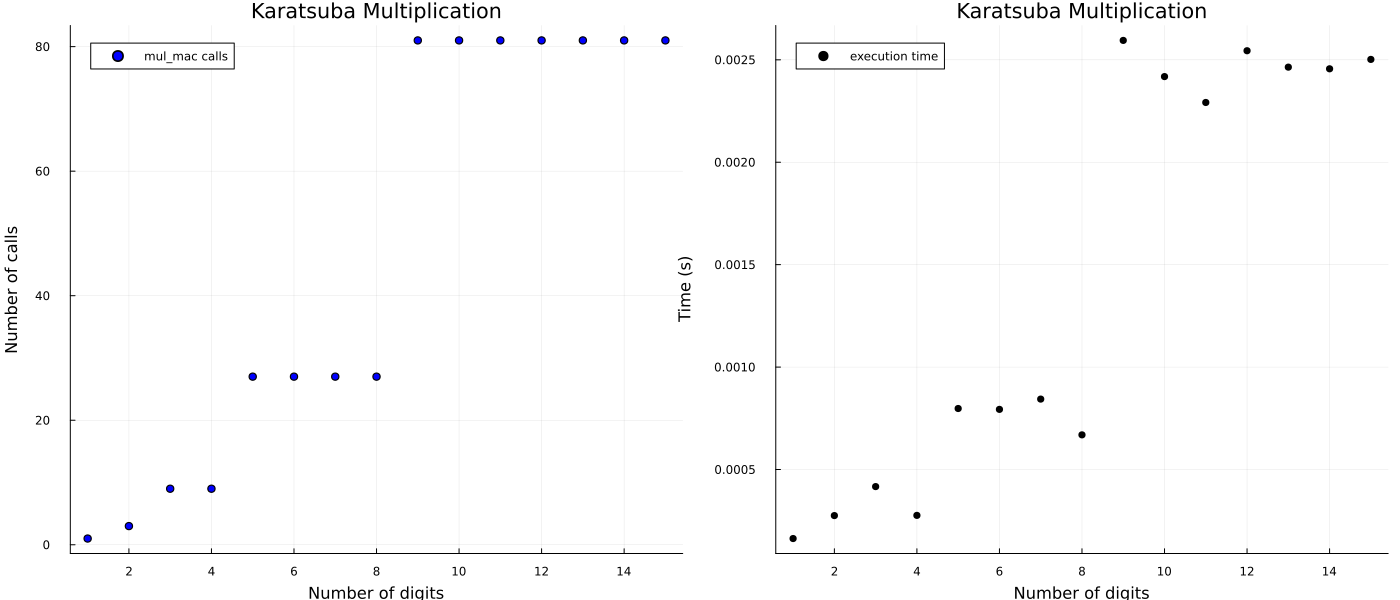

In [28]:
scatter(df_kmul.length, [df_kmul.count_mul df_kmul.time],
    layout = (1, 2), size=(1400, 600),
    markershape=:circle, seriescolor=[:blue :black],
    label=["mul_mac calls" "execution time"], xlabel="Number of digits\n", ylabel=["\n\nNumber of calls" "Time (s)"],
    title="Karatsuba Multiplication")